In [157]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import IPython
import random

from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from IPython.display import Image
from IPython.core.display import HTML

# Library for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Functions

In [155]:
# Function to reduce memory usage:
def reduce_memory_usage(df):
    # Print memory usage before changing datatypes
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before: {:.2f} MB'.format(start_mem))
    
    # Change datatypes
    for col in df.columns:
        col_type = df[col].dtype
        
        # Change datatypes only for integers or floats
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Change datatypes for integers
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            # Change datatypes for floats
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    # Print memory usage after changing datatypes
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage now : {:.2f} MB'.format(end_mem)) 
    print('Memory usage decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
# Function to display all the columns and rows
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 200
    display.max_rows = 200
    display.max_colwidth = 200
    display.width = None

# Fonction à appeler lorsqu'on veut afficher les valeurs exactes
# sur les barres des barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

# Function to display countplots for categorical features
def display_countplot(df, xlabel, ylabel,
                      x=None, y=None, hue=None, loc_legend='best',
                      hue_order=None):
    plt.figure(figsize=(18,5))
    sns.set_theme(style="darkgrid")
    
    g = sns.countplot(x=x, hue=hue, data=df, hue_order=hue_order)

    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=13)
    if hue == None:
        plt.title(f"Count of products by {xlabel}",
                  fontsize=20)
        show_values(g)
    else:
        plt.title(f"Count of products by {xlabel} and {hue}",
                  fontsize=20)
        plt.legend(loc=loc_legend, title=hue, 
                   title_fontsize='18', fontsize='15');
    
# SCORING : Calculation of 'Score_additives'
def create_score_additives(df):
    df['Score_additives'] = np.nan
    index_score_additives = df.columns.get_loc("Score_additives")
    index_additives_n = df.columns.get_loc("additives_n")
    for i in range(len(df.index)):
        if df.iloc[i,index_additives_n] == 0:
            df.iloc[i,index_score_additives] = 3
        elif 1 <= df.iloc[i,index_additives_n] <= 3:
            df.iloc[i,index_score_additives] = 2
        elif 4 <= df.iloc[i,index_additives_n] <= 8:
            df.iloc[i,index_score_additives] = 1
        else:
            df.iloc[i,index_score_additives] = 0
    return df

# Calculation of 'Score_nova'
def create_score_nova(df):
    df['Score_nova'] = 4 - df['nova_group']
    return df

# Function to assign the score nutritive to each product
def create_score_nutritive(df):
    df['Score_nutritive'] = np.nan
    index_group_nutritive = df.columns.get_loc("group_nutritive")
    index_score_nutritive = df.columns.get_loc("Score_nutritive")
    for i in range(len(df.index)):
        if df.iloc[i,index_group_nutritive] == "très bon":
            df.iloc[i,index_score_nutritive] = 4
        elif df.iloc[i,index_group_nutritive] == "bon":
            df.iloc[i,index_score_nutritive] = 3
        elif df.iloc[i,index_group_nutritive] == "moyen":
            df.iloc[i,index_score_nutritive] = 2
        elif df.iloc[i,index_group_nutritive] == "insuffisant":
            df.iloc[i,index_score_nutritive] = 1
        else:
            df.iloc[i,index_score_nutritive] = 0
    return df

# Function to display circles of PCA
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            fig, ax = plt.subplots(figsize=(10,10))

            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='18', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # display the circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display horizontal and vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Name of axes with the percentage of inertia
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Function to display factorial planes of PCA
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
      
            fig = plt.figure(figsize=(10,10))
            
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

# Function to display scree plot of PCA
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# Function to display dendrogram
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

# Exploratory Data Analysis

In [11]:
# Read the cleaned dataframe 'openfoodfacts'
openfoodfacts = pd.read_csv(
    "openfoodfacts_cleaned.csv",
    sep='\t',
    encoding='utf-8'
)

# Set the display options to show all columns and rows
set_pandas_display_options()

In [8]:
# Features
openfoodfacts.columns

Index(['code', 'url', 'image_url', 'product_name', 'categories_fr',
       'countries_fr', 'additives_n', 'nutriscore_score', 'nutriscore_grade',
       'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'main_category_fr',
       'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g',
       'fruits_vegetables_nuts_estimate_from_ingredients_100g'],
      dtype='object')

## Analysis of the categorical features

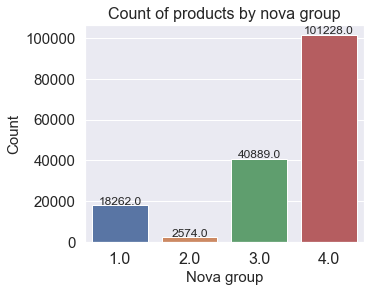

In [13]:
# Countplot for nova groups
plt.figure(figsize=(5, 4))
sns.set_theme(style="darkgrid")

g = sns.countplot(x="nova_group", data=openfoodfacts)

plt.yticks(fontsize=15)
plt.xticks(fontsize=16)
plt.xlabel("Nova group", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of products by nova group", fontsize=16)

show_values(g);

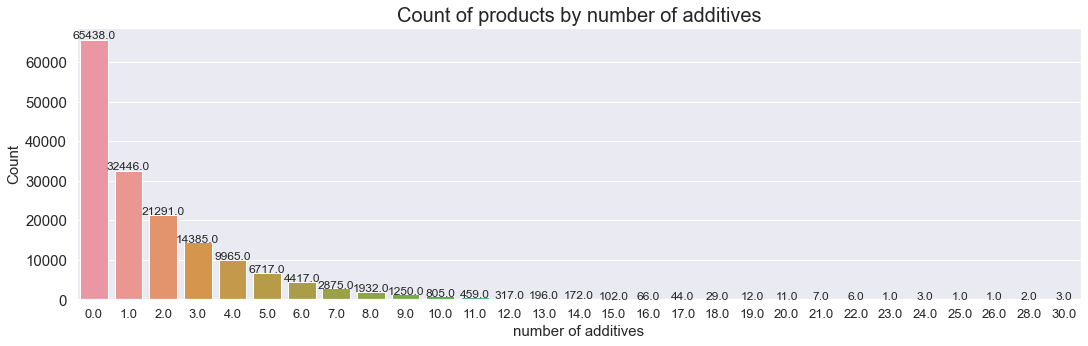

In [66]:
# Countplot for additives numbers
display_countplot(
    df=openfoodfacts, 
    xlabel="number of additives", 
    ylabel="Count", 
    x="additives_n", 
    y=None, 
    hue=None
)

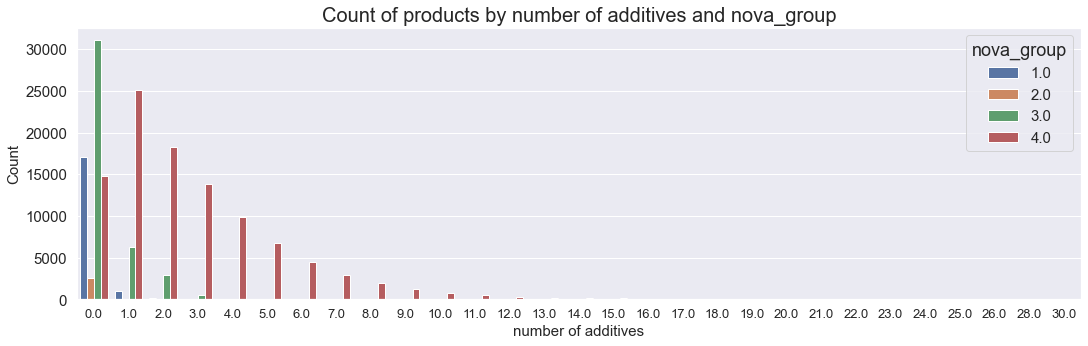

In [73]:
# Countplot for additives numbers by nova groups
display_countplot(
    df=openfoodfacts, 
    xlabel="number of additives", 
    ylabel="Count", 
    x="additives_n", 
    y=None, 
    hue="nova_group",
    loc_legend="upper right"
)

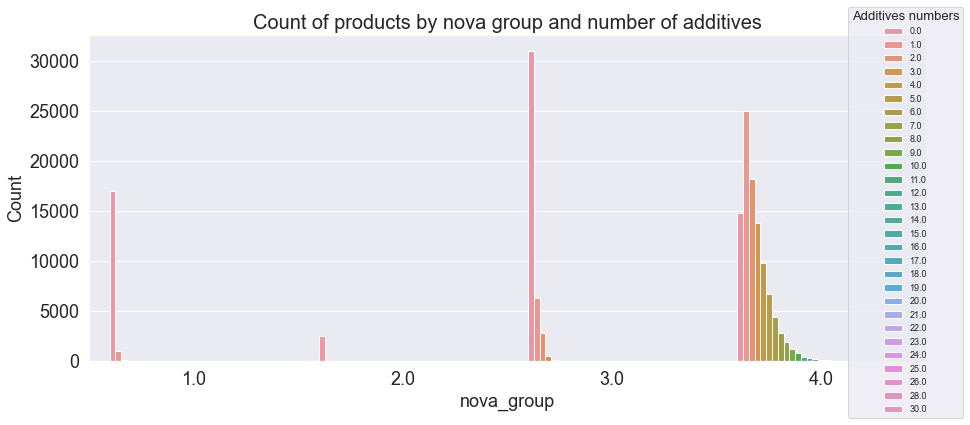

In [38]:
# Countplot for additives numbers by nova groups
plt.figure(figsize=(15,6))
sns.set_theme(style="darkgrid")
sns.countplot(x="nova_group", 
              hue="additives_n", 
              data=openfoodfacts)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel("nova_group", size=18)
plt.ylabel("Count", size=18)

plt.title("Count of products by nova group and number of additives", 
          fontsize=20)
plt.legend(loc='upper right',
           bbox_to_anchor=(0.9, 1.05, 0.15, 0.05),
           title='Additives numbers',
           title_fontsize='13',
           fontsize='9');

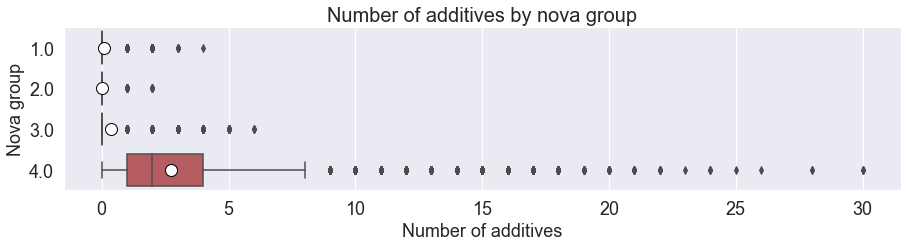

In [40]:
# Boxplot the number of additives by nova groups
order = openfoodfacts.groupby('nova_group')['additives_n'].median().sort_values().index

plt.figure(figsize=(15,3))
sns.boxplot(x="additives_n",
            y='nova_group',
            showfliers=True, # Display outliers
            orient='h',
            order=order,
            data=openfoodfacts,
            showmeans=True, # Display the mean
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"12"})

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel("Number of additives", size=18)
plt.ylabel("Nova group", size=18)
plt.title("Number of additives by nova group", fontsize=20);

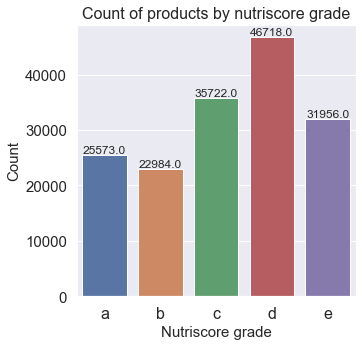

In [41]:
# Countplot of nutriscore grades
plt.figure(figsize=(5,5))
sns.set_theme(style="darkgrid")
g=sns.countplot(x="nutriscore_grade", 
                data=openfoodfacts, 
                order = ['a','b','c','d','e'])

plt.yticks(fontsize=15)
plt.xticks(fontsize=16)
plt.xlabel("Nutriscore grade", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of products by nutriscore grade", fontsize=16)

show_values(g);

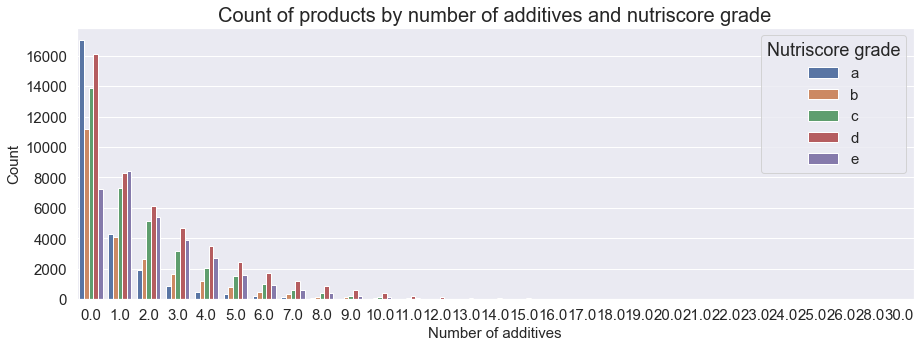

In [42]:
# Countplot of number of additives by nutriscore grade
plt.figure(figsize=(15,5))
sns.countplot(x="additives_n", 
              hue="nutriscore_grade", 
              data=openfoodfacts, 
              hue_order=['a','b','c','d','e'])

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Number of additives", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of products by number of additives and nutriscore grade", 
          fontsize=20)
plt.legend(loc='upper right',
          title='Nutriscore grade',
          title_fontsize='18',
          fontsize='15');

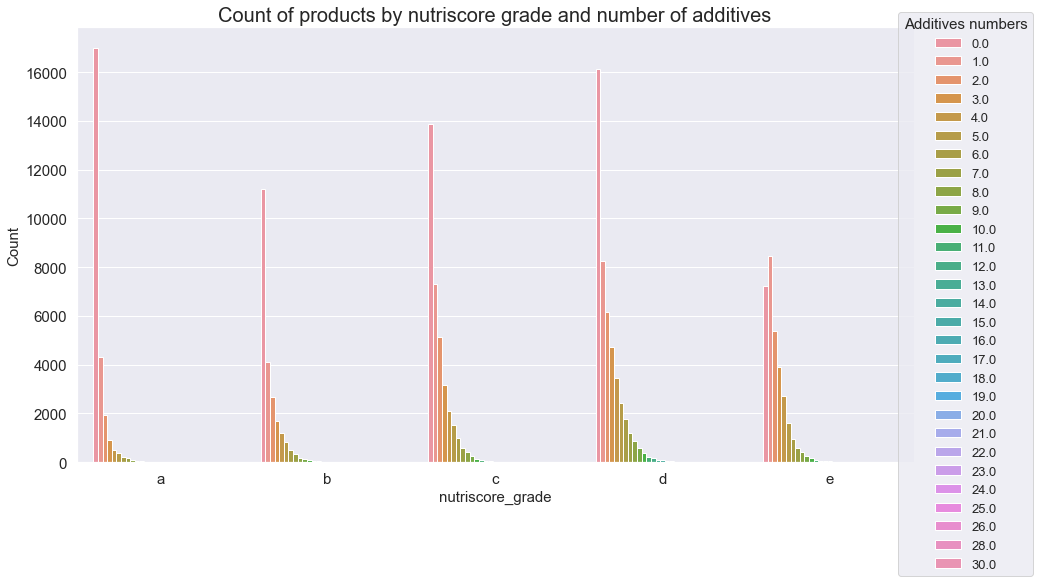

In [43]:
# Countplot of nutriscore grade by number of additives
plt.figure(figsize=(15,8))
g = sns.countplot(x="nutriscore_grade", 
                  hue="additives_n", 
                  data=openfoodfacts, 
                  order=['a','b','c','d','e'])

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("nutriscore_grade", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of products by nutriscore grade and number of additives", 
          fontsize=20)

plt.legend(loc='upper right',
           title='Additives numbers',
           bbox_to_anchor=(1, 1, 0.15, 0.05),
          title_fontsize='15',
          fontsize='13');

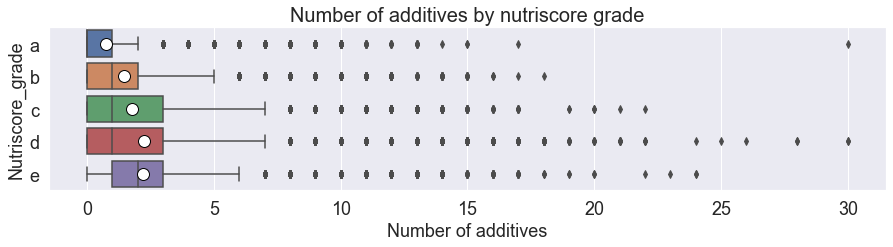

In [46]:
# Boxplot the number of additives by nutriscore grade
order = openfoodfacts.groupby('nutriscore_grade')['additives_n'].median().sort_values().index

plt.figure(figsize=(15,3))
sns.boxplot(x="additives_n",
            y='nutriscore_grade',
            showfliers=True, # Display outlier
            orient='h',
            order=order,
            data=openfoodfacts,
           showmeans=True,
           meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"12"})

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel("Number of additives", size=18)
plt.ylabel("Nutriscore_grade", size=18)
plt.title("Number of additives by nutriscore grade", fontsize=20);

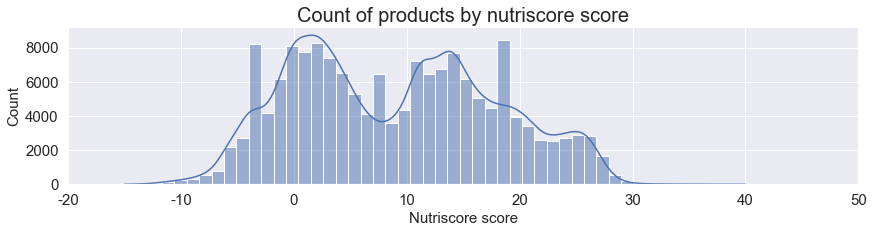

In [50]:
# Distribution of the number of products by nutriscore score
g = sns.displot(openfoodfacts, x="nutriscore_score", 
                bins=50, kde=True, height=3, aspect=4)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Nutriscore score", size=15)
plt.ylabel("Count", size=15)
g.set_xticklabels(['-20','-10','0','10','20','30', '40', '50'])
plt.title("Count of products by nutriscore score", 
          fontsize=20);

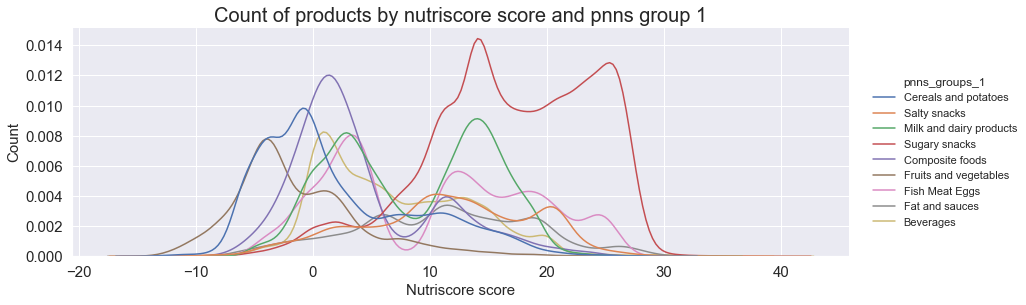

In [52]:
# Distribution of the number of products by nutriscore score and pnns_groups_1
sns.displot(openfoodfacts, x="nutriscore_score", hue="pnns_groups_1", 
            height=4, aspect=3, kind='kde')

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Nutriscore score", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of products by nutriscore score and pnns group 1", 
          fontsize=20);

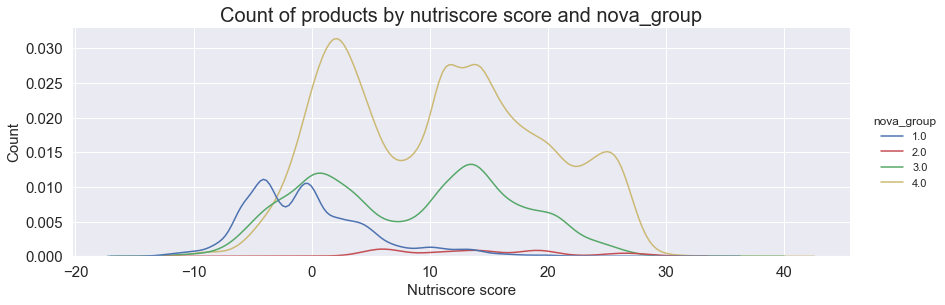

In [57]:
# Distribution of the number of products by nutriscore score and nova_group
sns.displot(openfoodfacts, x="nutriscore_score", hue="nova_group", 
            height=4, aspect=3, kind='kde', palette=['b', 'r', 'g', 'y'])

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Nutriscore score", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of products by nutriscore score and nova_group", 
          fontsize=20);

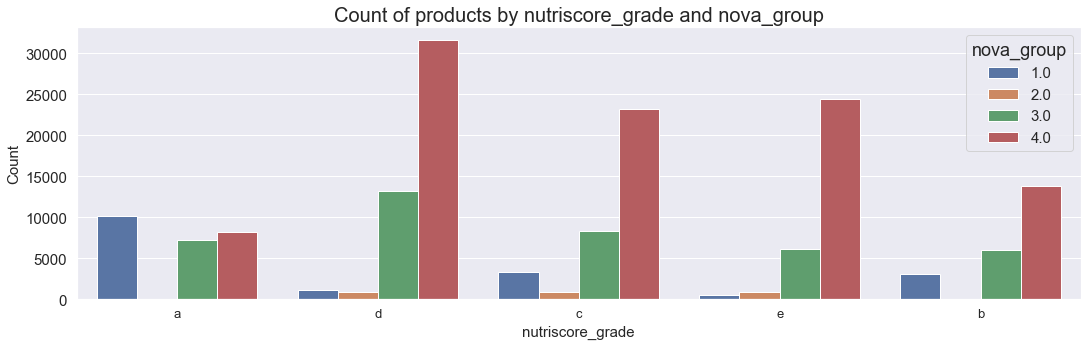

In [74]:
# Number of products by nutriscore grade and nova groups
display_countplot(
    df=openfoodfacts, 
    xlabel="nutriscore_grade", 
    ylabel="Count", 
    x="nutriscore_grade", 
    y=None, 
    hue="nova_group",
    loc_legend="upper right"
)

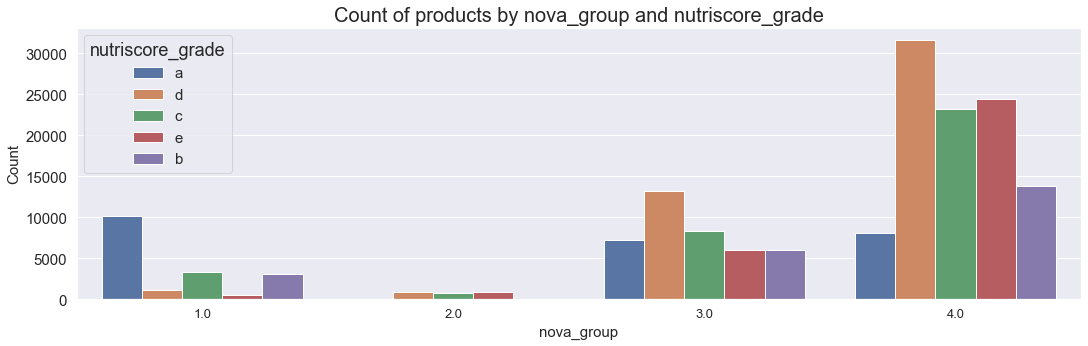

In [75]:
# Number of products by nova groups and nutriscore grade
display_countplot(
    df=openfoodfacts, 
    xlabel="nova_group", 
    ylabel="Count", 
    x="nova_group", 
    y=None, 
    hue="nutriscore_grade",
    loc_legend="upper left"
)

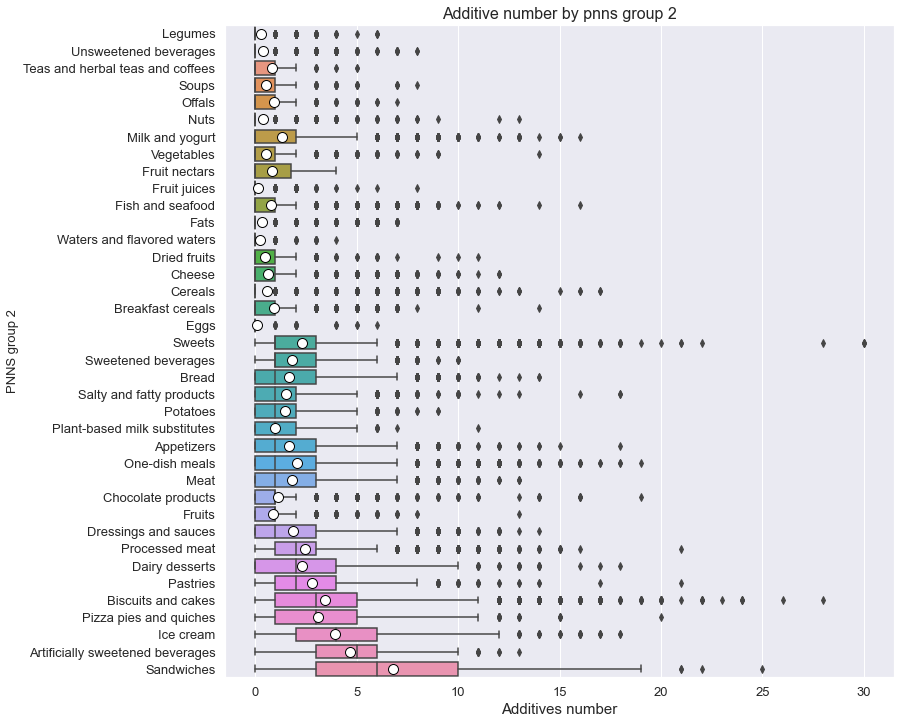

In [78]:
# Boxplot Additives numbers by pnns_groups_2
order = openfoodfacts.groupby('pnns_groups_2')['additives_n'].median().sort_values().index

plt.figure(figsize=(12,12))
sns.boxplot(x="additives_n",
           y='pnns_groups_2',
            showfliers=True,
           orient='h',
           order=order,
           data=openfoodfacts,
           showmeans=True,
           meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})

plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("Additives number", size=15)
plt.ylabel("PNNS group 2", size=13)
plt.title("Additive number by pnns group 2", fontsize=16);

## Analysis of quantitative feature

In [80]:
# Create a list of quantitative features
quant_columns = [
    'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g',
    'fruits_vegetables_nuts_estimate_from_ingredients_100g'
]

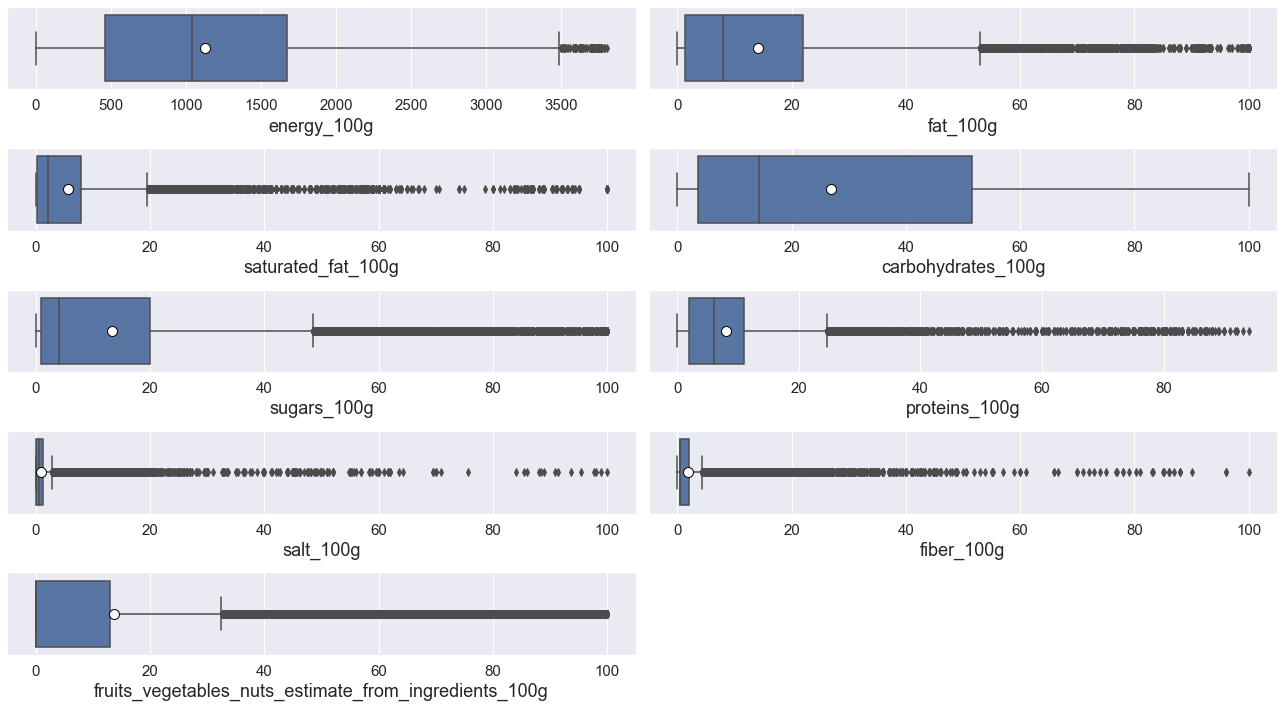

In [89]:
# Boxplots of quantitative features (with outliers)
plt.figure(figsize=(18, 10))
for i, col in enumerate(quant_columns):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data=openfoodfacts, x=col,
                showmeans=True, # Display the mean on the boxplot
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
    plt.xlabel(col, fontsize=18)
    plt.xticks(fontsize=15)
    plt.tight_layout()

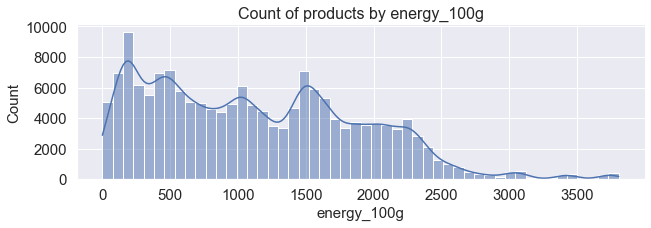

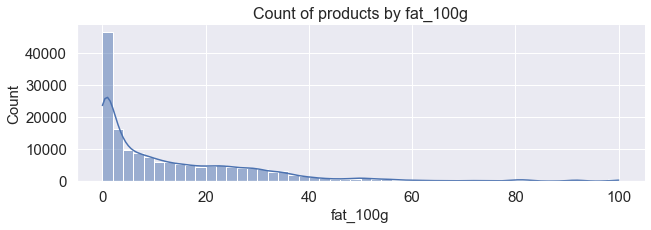

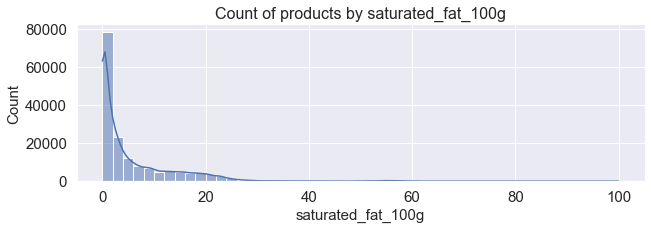

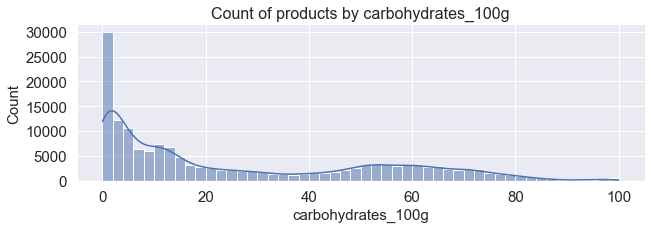

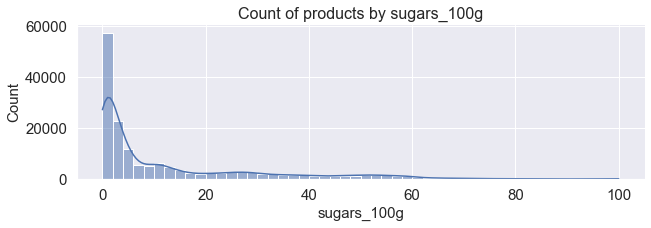

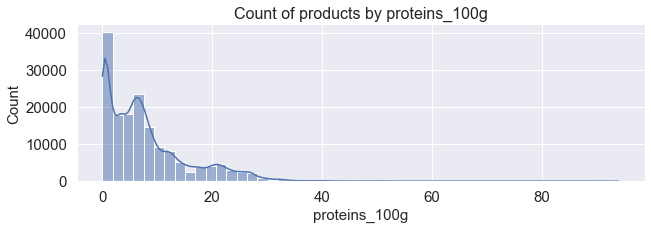

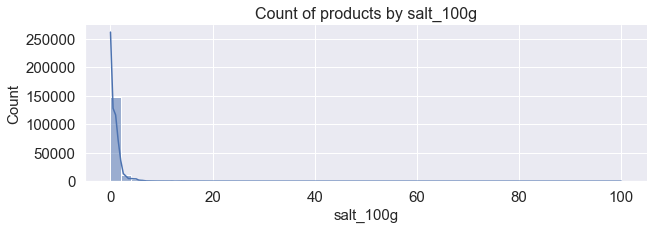

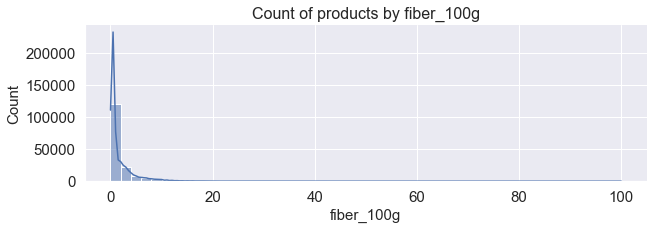

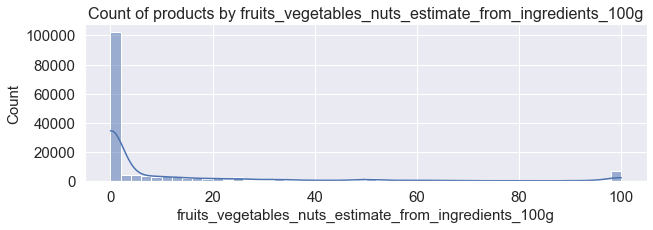

In [92]:
# Distribution of the number of products by quantitative features
for col in quant_columns:
    sns.displot(openfoodfacts, x=col, 
                bins=50, kde=True, height=3, aspect=3)

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel(col, size=15)
    plt.ylabel("Count", size=15)
    plt.title(f"Count of products by {col}", fontsize=16);

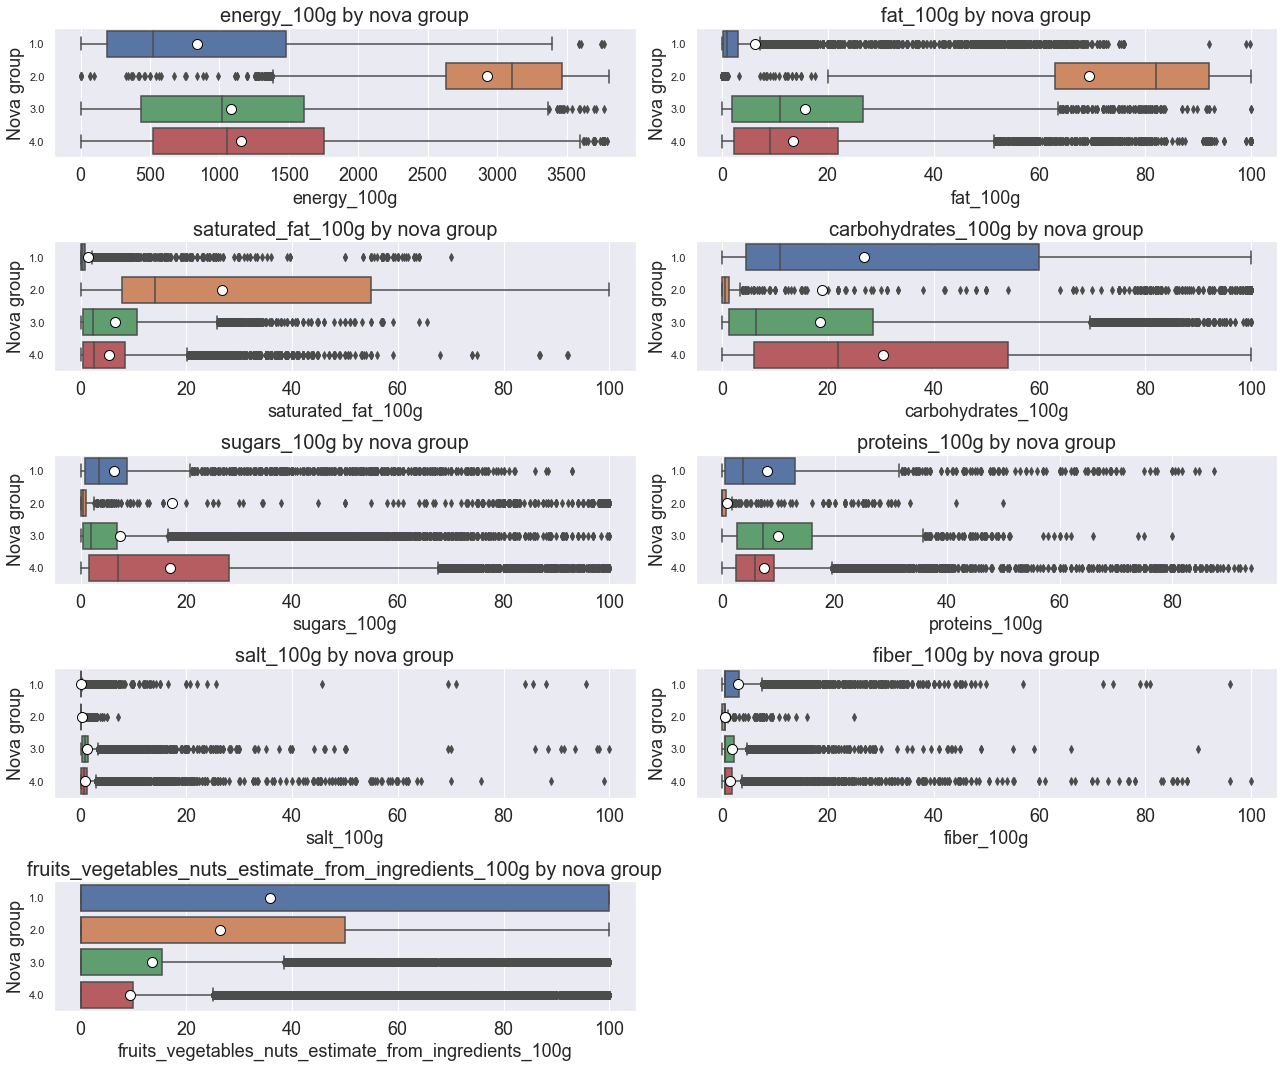

In [96]:
# Boxplots of quantitative features (with outliers) by nova groups
plt.figure(figsize=(18, 15))
for i, col in enumerate(quant_columns):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data=openfoodfacts, x=col, y='nova_group',
                showmeans=True, orient='h',
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
    plt.xlabel(col, fontsize=18)
    plt.ylabel("Nova group", size=18)
    plt.xticks(fontsize=18)
    plt.title(f"{col} by nova group", 
          fontsize=20);
    plt.tight_layout()

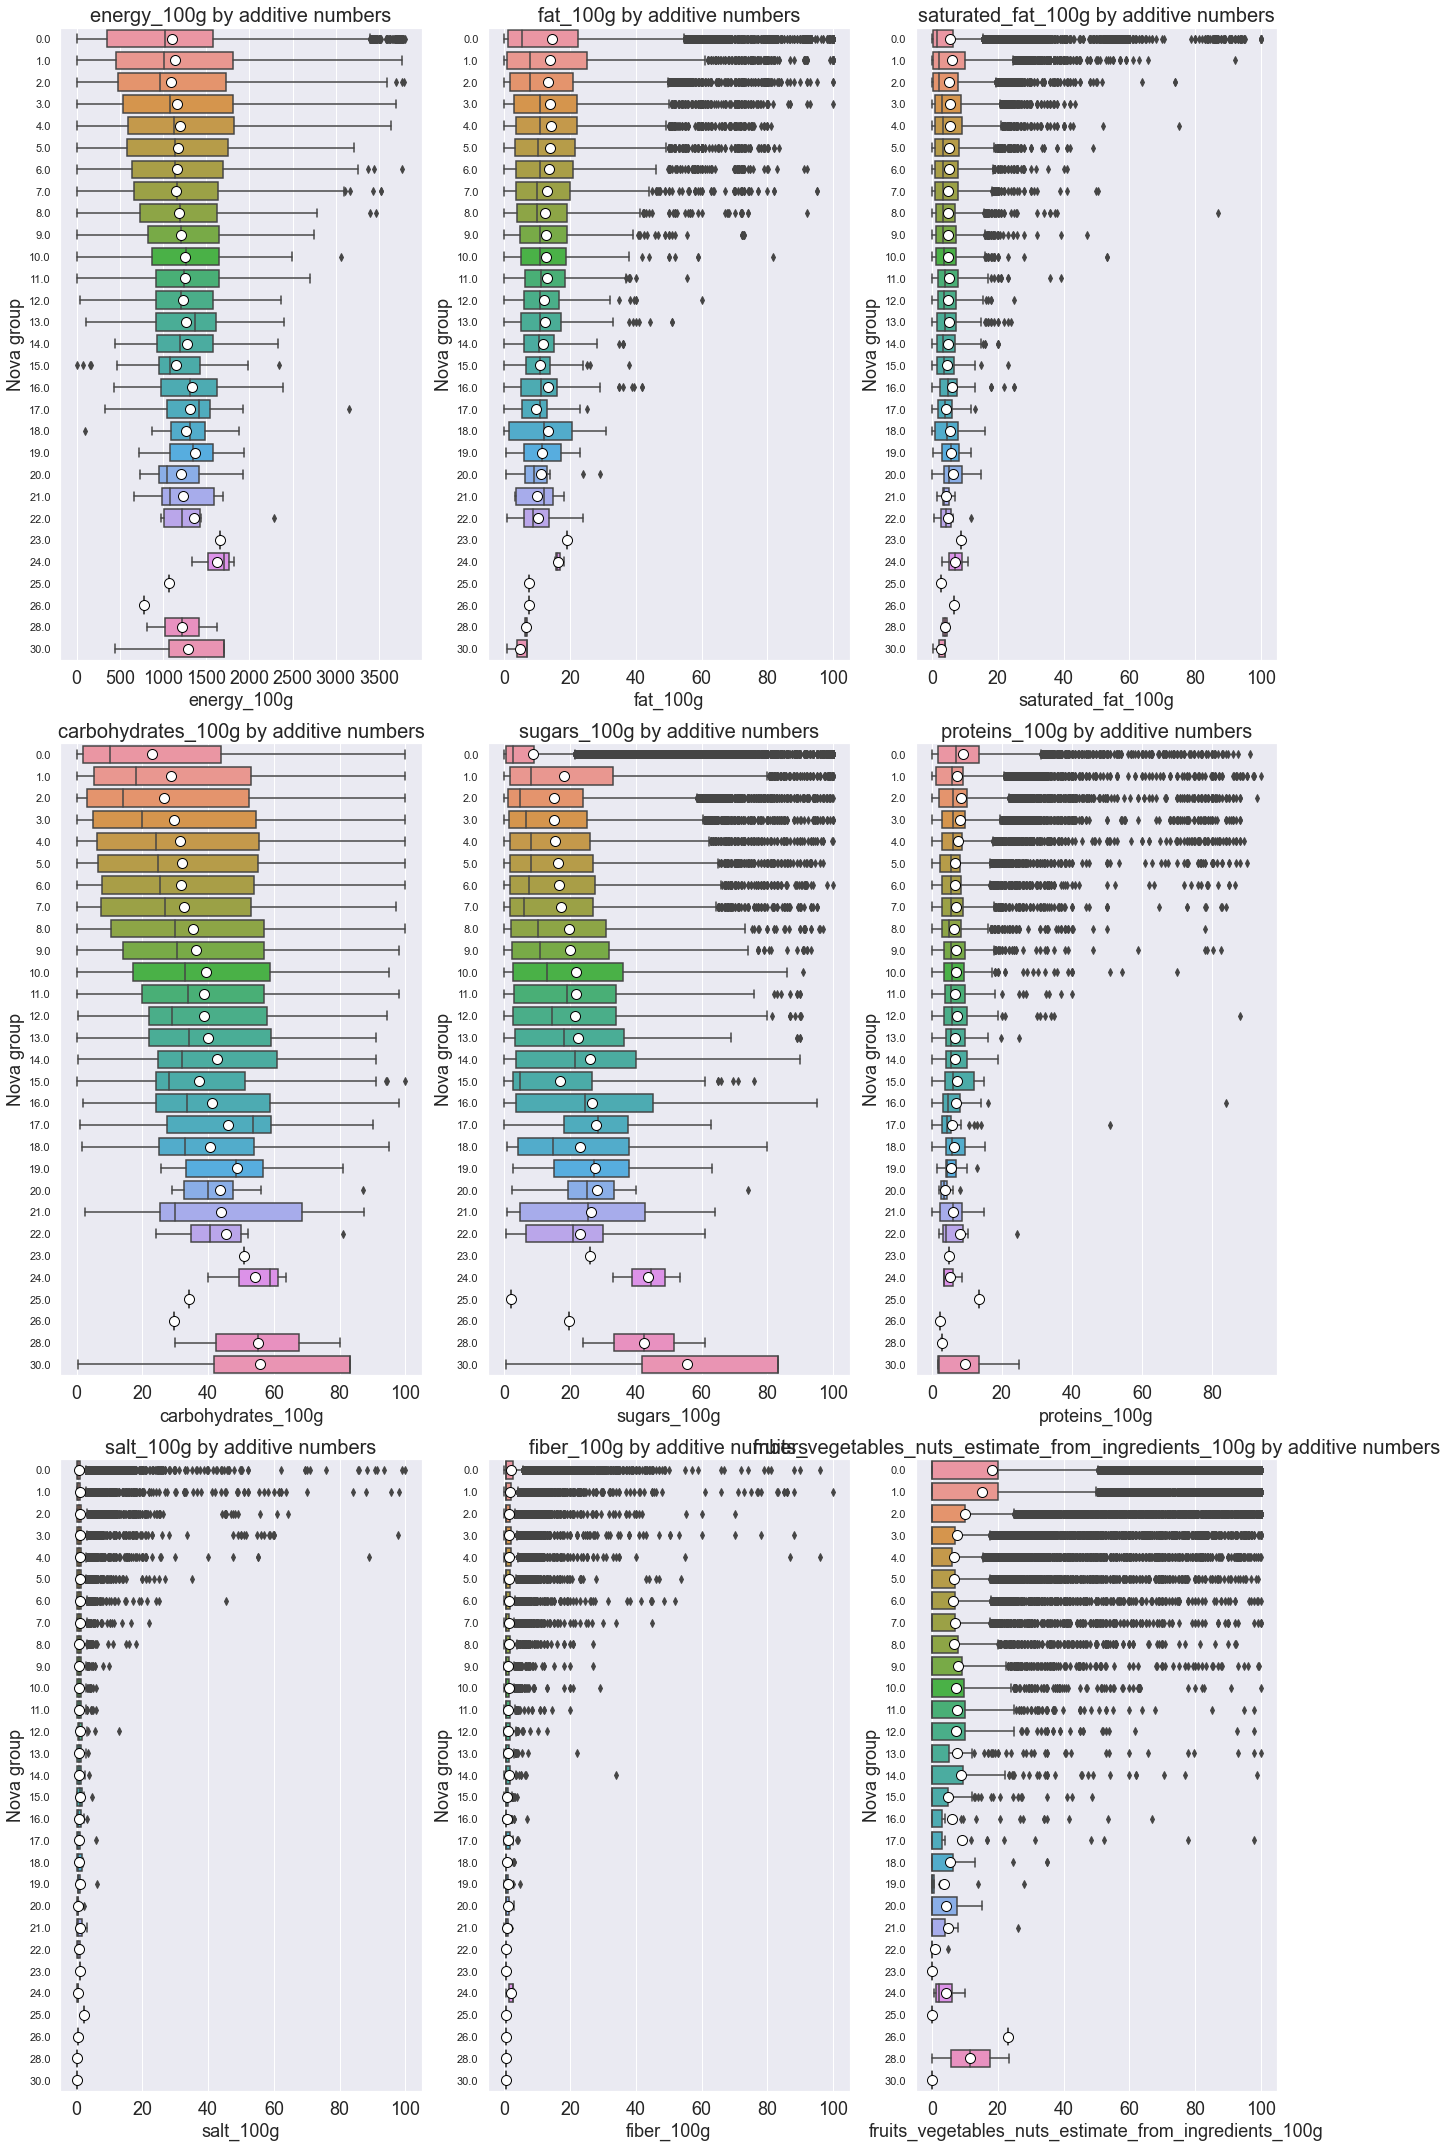

In [97]:
# Boxplots of quantitative features (with outliers) by additive numbers
plt.figure(figsize=(18, 30))
for i, col in enumerate(quant_columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=openfoodfacts, x=col, y='additives_n',
                showmeans=True, orient='h',
                meanprops={"marker":"o",
                           "markerfacecolor":"white",
                           "markeredgecolor":"black",
                           "markersize":"10"})
    plt.xlabel(col, fontsize=18)
    plt.ylabel("Nova group", size=18)
    plt.xticks(fontsize=18)
    plt.title(f"{col} by additive numbers", 
          fontsize=20);
    plt.tight_layout()

## Correlation Matrix

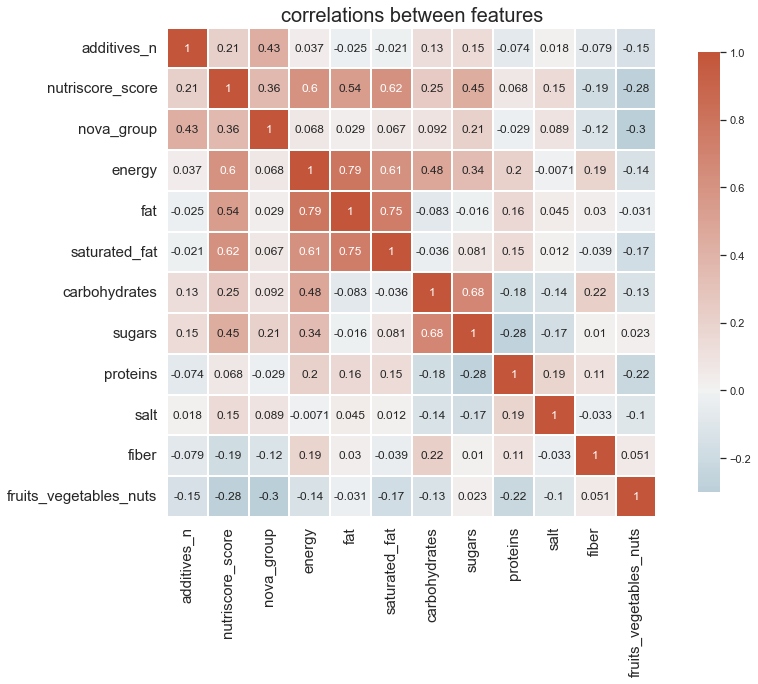

In [100]:
# Compute the correlation matrix between features
features = [
    'additives_n', 'nutriscore_score', 'nova_group', 'energy_100g',
    'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 
    'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g',
    'fruits_vegetables_nuts_estimate_from_ingredients_100g'
]

corr = openfoodfacts[features].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
colormap = sns.heatmap(corr, annot=True, annot_kws ={'size':12},
                       cmap=cmap, vmax=1, center=0,square=True, 
                       linewidths=2, cbar_kws={"shrink": .9})

feature_names = [
    'additives_n', 'nutriscore_score', 'nova_group', 'energy',
    'fat', 'saturated_fat', 'carbohydrates', 
    'sugars', 'proteins', 'salt', 'fiber',
    'fruits_vegetables_nuts'
]

plt.gca().set_yticklabels(feature_names)
plt.gca().set_xticklabels(feature_names)
colormap.set_xticklabels(colormap.get_xmajorticklabels(), 
                         fontsize=15, rotation=90)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), 
                         fontsize=15)
plt.title('correlations between features', fontsize=20);

- fat & saturated fat are highly correlated
- carbohydrates and sugars are highly correlated

# SCORING

In [104]:
# Create the list of useful columns for the application
# (fat and carbohydrates are not in this list)
columns_for_application = [
    'url', 'image_url', 'product_name',  'categories_fr', 
    'countries_fr', 'additives_n', 'nutriscore_score',
    'nutriscore_grade', 'nova_group', 'pnns_groups_1',
    'pnns_groups_2', 'main_category_fr', 'energy_100g',
    'saturated_fat_100g', 'sugars_100g', 'proteins_100g', 
    'salt_100g', 'fiber_100g',
    'fruits_vegetables_nuts_estimate_from_ingredients_100g'
]

In [105]:
# Create the dataframe with only useful columns
openfoodfacts = openfoodfacts[columns_for_application]

## SCORING for the APP "PureScore" : score / 10

### Score Nova :  / 3  
  -> 3/3 if Nova group 1  
  -> 2/3 if Nova group 2  
  -> 1/3 if Nova group 3  
  -> 0/3 if Nova group 4  

### Number of additives :  / 3  
  -> 3/3 if no additives  
  -> 2/3 if between 1 and 3 additives  
  -> 1/3 if between 4 and 8 additives 
  -> 0/3 if 9 additives or more  

### Nutrients & energy :  / 4  
  -> 4/4 if in the 1st quintile  
  -> 3/4 if in the 2nd quintile  
  -> 2/4 if in the 3rd quintile  
  -> 1/4 if in the 4th quintile  
  -> 0/4 if in the 5th quintile  

In [110]:
# SCORING : Calculation of 'Score_nova'
openfoodfacts = create_score_nova(openfoodfacts)

In [111]:
# SCORING : Calculation of 'Score_additives'
openfoodfacts = create_score_additives(openfoodfacts)

In [113]:
# SCORING : Calculation of score nutrients and energy
# 1st step : Normalize values
def mean_norm(df):
    return df.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [115]:
# Create the list of columns to normalize
nutrition_columns = openfoodfacts.filter(regex='_100g').columns.tolist()

In [117]:
# Normalize values
openfoodfacts[nutrition_columns] = mean_norm(openfoodfacts[nutrition_columns])

In [118]:
# Visualize nutrition columns
openfoodfacts[nutrition_columns]

,energy_100g,saturated_fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g
0,-0.600717,-0.624607,-0.690044,0.176109,-0.274887,-0.057394,-0.512400
1,1.965452,-0.143602,-0.501478,2.161756,-0.441095,2.331734,3.236430
2,-0.150168,1.287079,-0.560742,-0.305261,0.127260,-0.547471,-0.459917
3,0.659513,1.657083,-0.684657,2.643125,1.034718,-0.179913,-0.512400
4,-0.146251,0.793741,-0.663106,0.597307,-0.245275,-0.547471,-0.512400
...,...,...,...,...,...,...,...
162948,-1.380363,-0.686274,-0.490703,-0.967143,-0.442289,-0.394322,-0.512400
162949,-1.380363,-0.686274,-0.490703,-0.967143,-0.442289,-0.394322,-0.503028
162950,-1.380363,-0.686274,-0.490703,-0.967143,-0.442289,-0.394322,-0.512400
162951,-1.380363,-0.686274,-0.490703,-0.967143,-0.442289,-0.394322,-0.493656


In [119]:
# SCORING : Sum the scores of each nutrient 
# (+ or - depending on the nutrient)
# Nutrients + : proteins, fibers, fruits/vegetables/nuts
# Nutrients - : energy, saturated_fat, salt, sugars
openfoodfacts['Sum_nutritive'] = (openfoodfacts['proteins_100g'] 
                                 + openfoodfacts['fiber_100g'] 
                                 + openfoodfacts['fruits_vegetables_nuts_estimate_from_ingredients_100g'] 
                                 - openfoodfacts['energy_100g'] 
                                 - openfoodfacts['saturated_fat_100g'] 
                                 - openfoodfacts['sugars_100g'] 
                                 - openfoodfacts['salt_100g'])

In [122]:
# Cut the values of the 'Sum_nutritive' column into 5 groups (quintiles)
openfoodfacts['group_nutritive'] = pd.qcut(
    openfoodfacts['Sum_nutritive'],
    5,
    labels=["mauvais", "insuffisant", "moyen", "bon", "très bon"]
)

In [123]:
# Calculate the score nutritive
openfoodfacts = create_score_nutritive(openfoodfacts)

In [124]:
# SCORING : Calculate the PureScore
openfoodfacts['PureScore'] = (openfoodfacts['Score_nutritive']
                             + openfoodfacts['Score_additives'] 
                             + openfoodfacts['Score_nova'])

## Analysis of PureScore

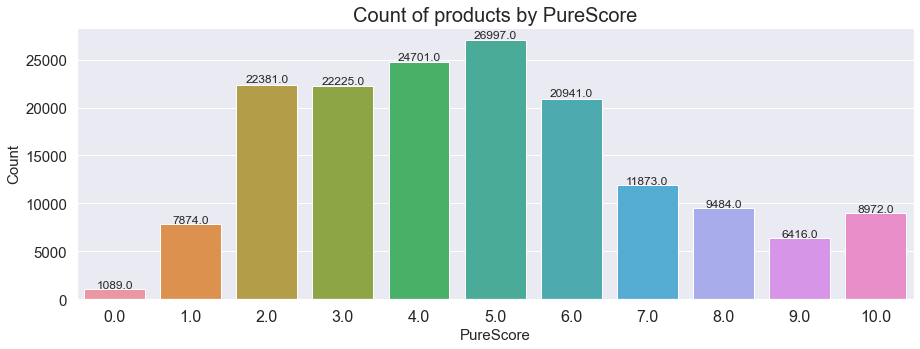

In [126]:
# Count of products by PureScore
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")

g = sns.countplot(x="PureScore", data=openfoodfacts)
plt.yticks(fontsize=15)
plt.xticks(fontsize=16)
plt.xlabel("PureScore", size=15)
plt.ylabel("Count", size=15)
plt.title("Count of products by PureScore", fontsize=20)

show_values(g);

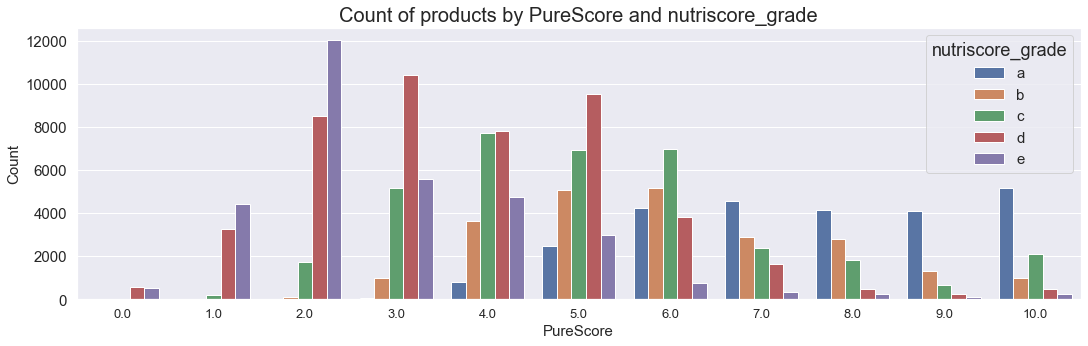

In [134]:
# Number of products by PureScore and Nutriscore Grade
display_countplot(df=openfoodfacts, 
                  xlabel='PureScore', 
                  ylabel='Count', 
                  x="PureScore", 
                  y=None, 
                  hue="nutriscore_grade", 
                  loc_legend='best',
                  hue_order=['a','b','c','d','e'])

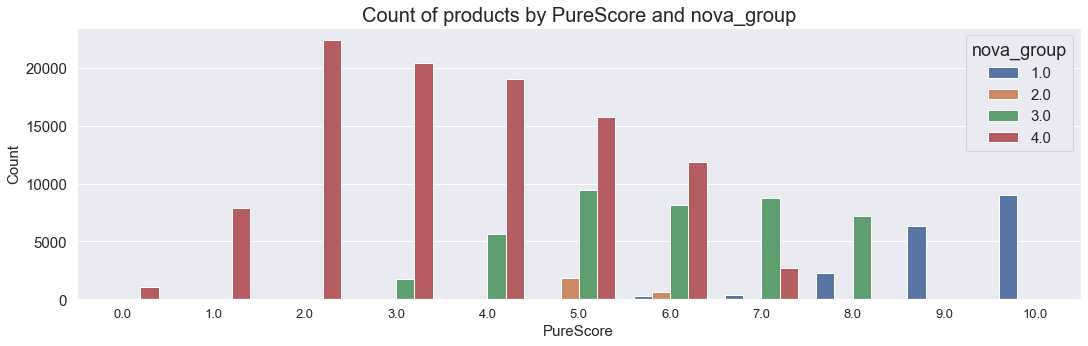

In [136]:
# Number of products by PureScore and Nova Group
display_countplot(df=openfoodfacts, 
                  xlabel='PureScore', 
                  ylabel='Count', 
                  x="PureScore", 
                  y=None, 
                  hue="nova_group", 
                  loc_legend='upper right',
                  hue_order=None)

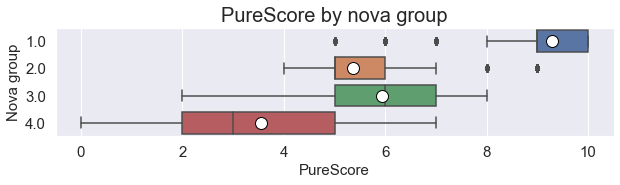

In [137]:
# Boxplot PureScore by nova group
plt.figure(figsize=(10,2))
sns.boxplot(x="PureScore", y='nova_group',
            showfliers=True, orient='h',
            data=openfoodfacts,
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"12"})

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("PureScore", size=15)
plt.ylabel("Nova group", size=15)
plt.title("PureScore by nova group", fontsize=20);

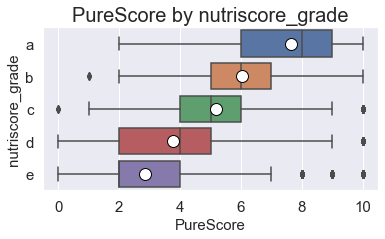

In [141]:
# Boxplot PureScore by nutriscore grade
plt.figure(figsize=(6,3))
sns.boxplot(x="PureScore", y='nutriscore_grade',
            showfliers=True, orient='h',
            data=openfoodfacts,
            order = ['a','b','c','d','e'],
            showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"12"})

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("PureScore", size=15)
plt.ylabel("nutriscore_grade", size=15)
plt.title("PureScore by nutriscore_grade", fontsize=20);

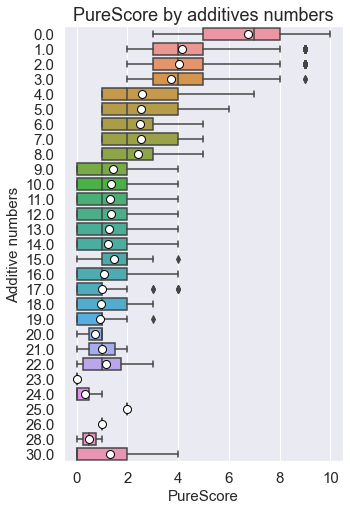

In [142]:
# Boxplot PureScore by number of additives
plt.figure(figsize=(5,8))
sns.boxplot(x="PureScore",
            y='additives_n',
            showfliers=True,
            orient='h',
            data=openfoodfacts,
           showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"8"})

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("PureScore", size=15)
plt.ylabel("Additive numbers", size=15)
plt.title("PureScore by additives numbers", fontsize=18);

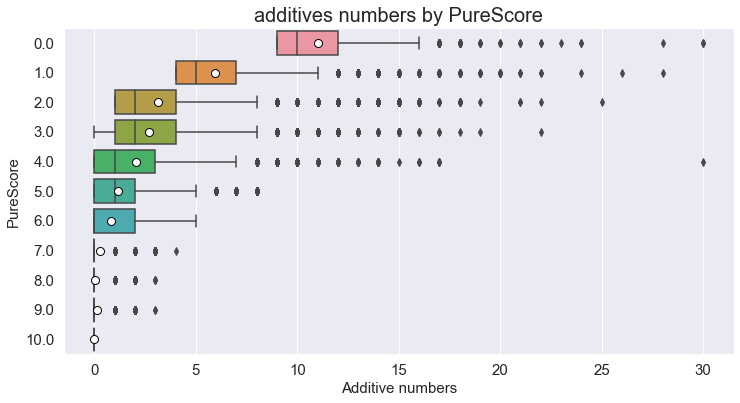

In [145]:
# Boxplot Additives number by PureScore
plt.figure(figsize=(12,6))

sns.boxplot(x="additives_n",
            y='PureScore',
            showfliers=True,
            orient='h',
            data=openfoodfacts,
           showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"8"})

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Additive numbers", size=15)
plt.ylabel("PureScore", size=15)
plt.title("additives numbers by PureScore", fontsize=20);

## PCA

In [150]:
# PCA (Principal Component Analysis)
from sklearn import decomposition
from sklearn import preprocessing

In [151]:
# Create the list of pnns_1 categories
pnns_1 = openfoodfacts['pnns_groups_1'].unique().tolist()

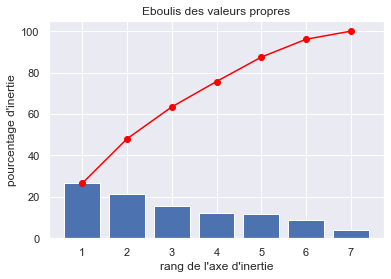

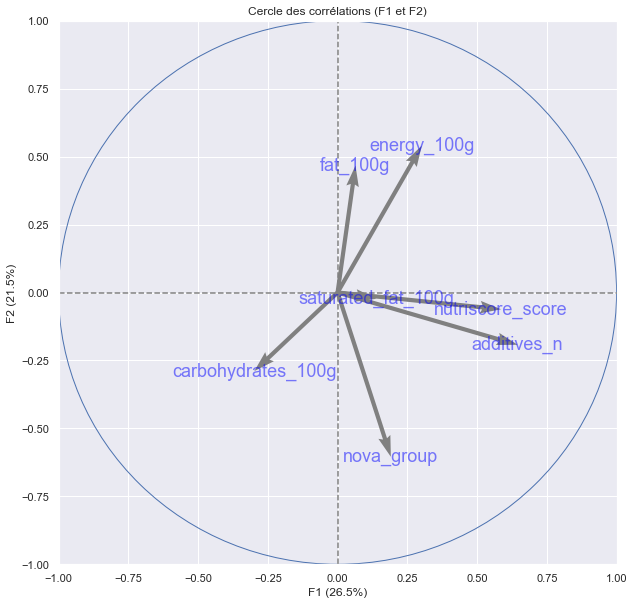

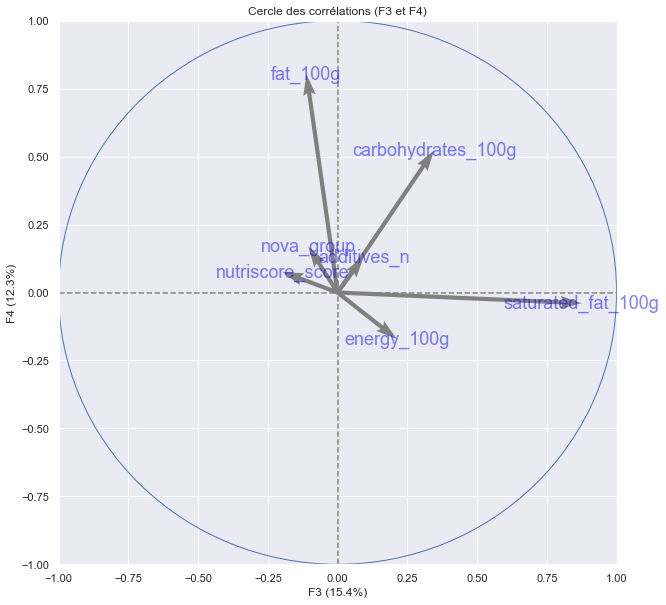

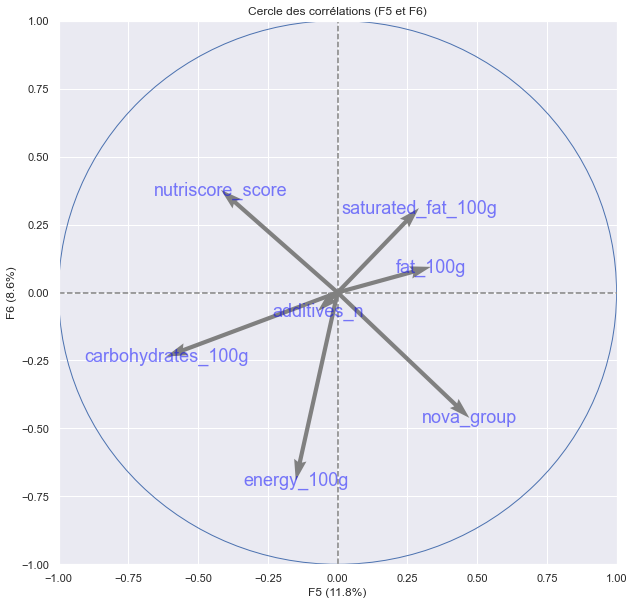

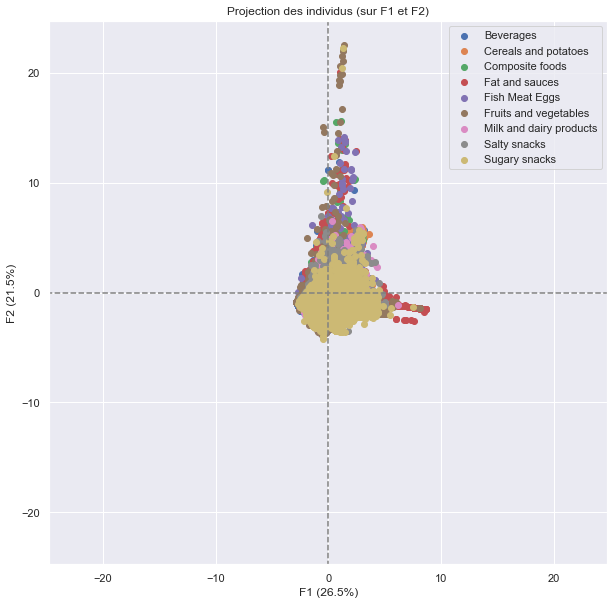

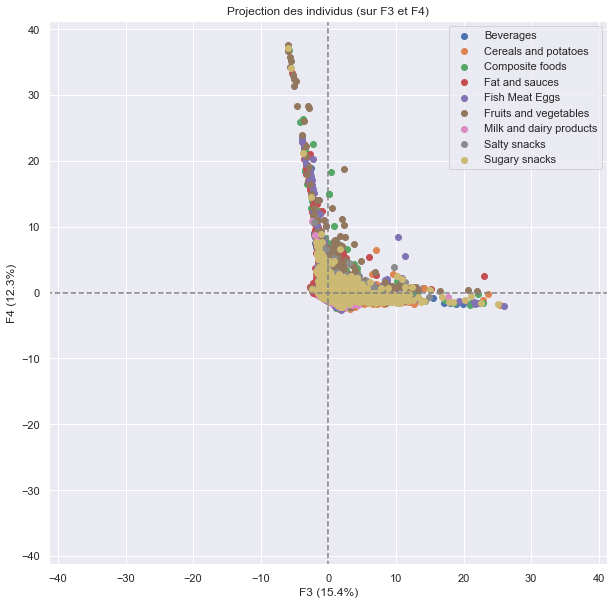

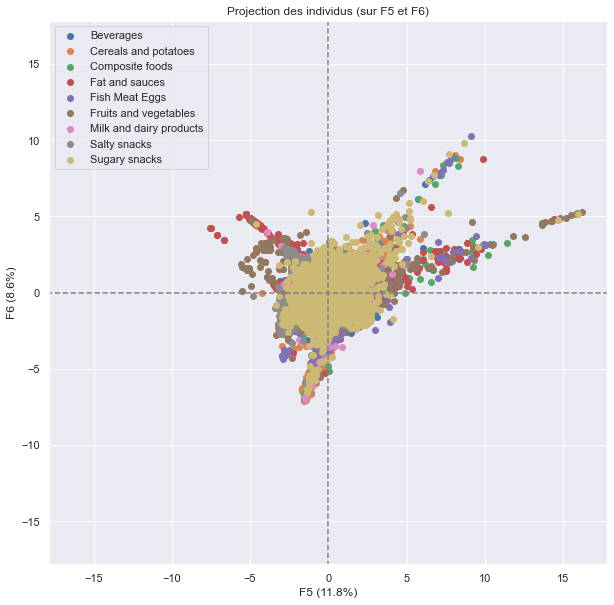

In [156]:
# number of components to calculate
n_comp = 7

# selection of the columns to be taken into account in the PCA
columns_pca = [
    'energy_100g', 'saturated_fat_100g', 'sugars_100g', 'proteins_100g',
    'salt_100g', 'fiber_100g', 'fruits_vegetables_nuts_estimate_from_ingredients_100g']

# pnns_groups_1 for each product
pnns_1 = [openfoodfacts.loc[i ,"pnns_groups_1"] for i in openfoodfacts.index]

# preparing data for PCA
X = openfoodfacts[columns_pca].values

# Standardize data
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calculation of principal components
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Display Scree of eigenvalues
display_scree_plot(pca)

# Display Circle of correlations
pcs = pca.components_
display_circles(pcs, n_comp, pca, 
                [(0,1),(2,3),(4,5)], 
                labels = np.array(features))

# Projection of products
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, 
                         [(0,1),(2,3),(4,5)],
                         illustrative_var = pnns_1,
                         alpha=1)

plt.show()

# APPLICATION

In [163]:
# url path for nova groups logos
Nova_group_1_url = "https://imagizer.imageshack.com/img924/5082/yAHzxE.png"
Nova_group_2_url = "https://imagizer.imageshack.com/img924/5752/GxvEyW.png"
Nova_group_3_url = "https://imagizer.imageshack.com/img922/9497/3qMpGb.png"
Nova_group_4_url = "https://imagizer.imageshack.com/img924/5017/58VPzp.png"

# url path for purescore logos
PureScore_10_url = "https://imagizer.imageshack.com/img922/6058/REXrWU.png"
PureScore_9_url = "https://imagizer.imageshack.com/img923/7103/OXi61E.png"
PureScore_8_url = "https://imagizer.imageshack.com/img922/742/yzH4yg.png"
PureScore_7_url = "https://imagizer.imageshack.com/img923/3283/CLMhY5.png"
PureScore_6_url = "https://imagizer.imageshack.com/img923/406/yEQt8t.png"
PureScore_5_url = "https://imagizer.imageshack.com/img923/4369/GShaP8.png"
PureScore_4_url = "https://imagizer.imageshack.com/img924/2572/q5bXRw.png"
PureScore_3_url = "https://imagizer.imageshack.com/img922/552/dGCp9m.png"
PureScore_2_url = "https://imagizer.imageshack.com/img923/9462/MEMDyA.png"
PureScore_1_url = "https://imagizer.imageshack.com/img922/703/e4wZkv.png"
PureScore_0_url = "https://imagizer.imageshack.com/img924/2752/zQVEpm.png"

# function to display the logo corresponding to the nova group
def return_nova_group(product_nova, product_nova_group): 
    if product_nova == 1:
        product_nova_group.append(Nova_group_1_url)
    elif product_nova == 2:
        product_nova_group.append(Nova_group_2_url)
    elif product_nova == 3:
        product_nova_group.append(Nova_group_3_url)
    else:
        product_nova_group.append(Nova_group_4_url)
    return product_nova_group

# Function to save the comment corresponding to the nova group
def return_nova_comment(product_nova, product_nova_comment): 
    if product_nova == 1:
        product_nova_comment.append("Aliment peu ou pas transformé")
    elif product_nova == 2:
        product_nova_comment.append("Ingrédient culinaire")
    elif product_nova == 3:
        product_nova_comment.append("Aliment transformé")
    else:
        product_nova_comment.append("Aliment ultra-transformé")
    return product_nova_comment

# function to display the logo corresponding to PureScore
def return_PureScore(product_PureScore, product_PureScore_logo): 
    if product_PureScore == 10:
        product_PureScore_logo.append(PureScore_10_url)
    elif product_PureScore == 9:
        product_PureScore_logo.append(PureScore_9_url)
    elif product_PureScore == 8:
        product_PureScore_logo.append(PureScore_8_url)
    elif product_PureScore == 7:
        product_PureScore_logo.append(PureScore_7_url)
    elif product_PureScore == 6:
        product_PureScore_logo.append(PureScore_6_url)
    elif product_PureScore == 5:
        product_PureScore_logo.append(PureScore_5_url)
    elif product_PureScore == 4:
        product_PureScore_logo.append(PureScore_4_url)
    elif product_PureScore == 3:
        product_PureScore_logo.append(PureScore_3_url)
    elif product_PureScore == 2:
        product_PureScore_logo.append(PureScore_2_url)
    elif product_PureScore == 1:
        product_PureScore_logo.append(PureScore_1_url)
    else:
        product_PureScore_logo.append(PureScore_0_url)
    return product_PureScore_logo

# Converting links to html tags
def path_to_image_html_product(path):
    return '<img src="'+ path + '" width="100" >'
    
def path_to_image_html_nova(path):
    return '<img src="'+ path + '" width="60" >'
    
def path_to_image_html_PureScore(path):
    return '<img src="'+ path + '" width="150" >'

# Function to test the application
def test_PureScore(df):

    # create the dataframe containing all the information of the scanned product
    scanned_product = df.sample()
    
    # characteristics of the scanned product
    Scanned_name = scanned_product.iloc[0]['product_name']
    Scanned_additifs = scanned_product.iloc[0]['additives_n']
    Scanned_nova = scanned_product.iloc[0]['nova_group']
    Scanned_pnns_2 = scanned_product.iloc[0]['pnns_groups_2']
    Scanned_pnns_1 = scanned_product.iloc[0]['pnns_groups_1']
    Scanned_main_category = scanned_product.iloc[0]['main_category_fr']
    Scanned_PureScore = scanned_product.iloc[0]['PureScore']
    Scanned_image_url = scanned_product.iloc[0]['image_url']
    
    # dataframes from group filters (pnns 1 & 2 and main category)
    main_category = df[df['main_category_fr'] == Scanned_main_category]
    pnns_2 = df[df['pnns_groups_2'] == Scanned_pnns_2]
    pnns_1 = df[df['pnns_groups_1'] == Scanned_pnns_1]
    
    # Display the logo corresponding to the nova group
    Scanned_nova_group = []
    return_nova_group(Scanned_nova, Scanned_nova_group)
    
    # Save the comment corresponding to the nova group
    Scanned_nova_comment = []
    return_nova_comment(Scanned_nova, Scanned_nova_comment)
    
    # Display the logo corresponding to the PureScore
    Scanned_PureScore_logo = []
    return_PureScore(Scanned_PureScore, Scanned_PureScore_logo)
    
    # New part: propose an alternative product from the same main category
    
    # Creation of the filter allowing a product:
    # - belonging to the same main category as the scanned product,
    # - with a score between max score and max score - 1
    # - and greater than or equal to the scanned product score
    filter_main_cat_score_max = (
        (df["main_category_fr"] == Scanned_main_category)
        & (main_category['PureScore'] >= (main_category['PureScore'].max() - 1))
        & (main_category['PureScore'] >= Scanned_PureScore)
    )
    
    # Create the dataframe containing all the information of the proposed alternative
    alternative_main_category = df[filter_main_cat_score_max].sample()

    # Define the characteristics of the proposed alternative
    Alternative_name = alternative_main_category.iloc[0]['product_name']
    Alternative_additifs = alternative_main_category.iloc[0]['additives_n']
    Alternative_nova = alternative_main_category.iloc[0]['nova_group']
    Alternative_PureScore = alternative_main_category.iloc[0]['PureScore']
    Alternative_image_url = alternative_main_category.iloc[0]['image_url']

    # url associated with the nova group
    Alternative_nova_group = []
    return_nova_group(Alternative_nova, Alternative_nova_group)
    
    # Comment associated with the nova group
    Alternative_nova_comment = []
    return_nova_comment(Alternative_nova, Alternative_nova_comment)
    
    # url associated to the pure score
    Alternative_PureScore_logo = []
    return_PureScore(Alternative_PureScore, Alternative_PureScore_logo)
    
    # New part: propose an alternative product from the same pnns 2 group

    # Creation of a filter allowing to propose a product belonging to
    # to the same pnns 2 group as the scanned product and presenting an optimal score
    filter_pnns_2_score_max = (
        (openfoodfacts["pnns_groups_2"] == Scanned_pnns_2)
        & (pnns_2['PureScore'] >= (pnns_2['PureScore'].max() - 1))
        & (pnns_2['PureScore'] >= Scanned_PureScore)
    )
    
    # Create the dataframe containing all the information of the proposed alternative
    alternative_pnns_2 = df[filter_pnns_2_score_max].sample()
    
    # Define the characteristics of the proposed alternative 
    Alternative_name_2 = alternative_pnns_2.iloc[0]['product_name']
    Alternative_additifs_2 = alternative_pnns_2.iloc[0]['additives_n']
    Alternative_nova_2 = alternative_pnns_2.iloc[0]['nova_group']
    Alternative_PureScore_2 = alternative_pnns_2.iloc[0]['PureScore']
    Alternative_image_url_2 = alternative_pnns_2.iloc[0]['image_url']

    # url, comment nova associated with the nova group and PureScore
    Alternative_nova_group_2 = []
    return_nova_group(Alternative_nova_2, Alternative_nova_group_2)
    
    Alternative_nova_comment_2 = []
    return_nova_comment(Alternative_nova_2, Alternative_nova_comment_2)
    
    Alternative_PureScore_logo_2 = []
    return_PureScore(Alternative_PureScore_2, Alternative_PureScore_logo_2)
    
    # New part: propose an alternative product from the same pnns 1 group

    # Creation of a filter allowing to propose a product belonging to
    # to the same pnns 2 group as the scanned product and presenting an optimal score
    filter_pnns_1_score_max = (
        (df["pnns_groups_1"] == Scanned_pnns_1)
        & (pnns_1['PureScore'] >= (pnns_1['PureScore'].max() - 1))
        & (pnns_1['PureScore'] >= Scanned_PureScore)
    )
    
    # Create the dataframe containing all the information of the proposed alternative
    alternative_pnns_1 = df[filter_pnns_1_score_max].sample()
    
    # Define the characteristics of the proposed alternative 
    Alternative_name_3 = alternative_pnns_1.iloc[0]['product_name']
    Alternative_additifs_3 = alternative_pnns_1.iloc[0]['additives_n']
    Alternative_nova_3 = alternative_pnns_1.iloc[0]['nova_group']
    Alternative_PureScore_3 = alternative_pnns_1.iloc[0]['PureScore']
    Alternative_image_url_3 = alternative_pnns_1.iloc[0]['image_url']

    # url, comment nova associated with the nova group and PureScore
    Alternative_nova_group_3 = []
    return_nova_group(Alternative_nova_3, Alternative_nova_group_3)
    
    Alternative_nova_comment_3 = []
    return_nova_comment(Alternative_nova_3, Alternative_nova_comment_3)
    
    Alternative_PureScore_logo_3 = []
    return_PureScore(Alternative_PureScore_3, Alternative_PureScore_logo_3)
    
    
    # Display of results in tabular form
    results = pd.DataFrame(
        {'Product':['Scanned Product',
                    'Alternative category',
                    'Alternative sous-group',
                    'Alternative group'],
         'Product_Name': [Scanned_name,
                          Alternative_name,
                          Alternative_name_2,
                          Alternative_name_3],
         'Product_Image': [Scanned_image_url,
                           Alternative_image_url,
                           Alternative_image_url_2,
                           Alternative_image_url_3],
         'Additives_Number': [Scanned_additifs,
                              Alternative_additifs,
                              Alternative_additifs_2,
                              Alternative_additifs_3],
         'Groupe_Nova': [Scanned_nova_group[0],
                         Alternative_nova_group[0],
                         Alternative_nova_group_2[0],
                         Alternative_nova_group_3[0]],
         'Transformation_grade': [Scanned_nova_comment[0],
                                  Alternative_nova_comment[0],
                                  Alternative_nova_comment_2[0],
                                  Alternative_nova_comment_3[0]],
         'PureScore': [Scanned_PureScore_logo[0],
                       Alternative_PureScore_logo[0],
                       Alternative_PureScore_logo_2[0],
                       Alternative_PureScore_logo_3[0]]}
    )
    
    results.set_index('Product', inplace=True)
    
    # Rendering the dataframe as HTML table
    results.to_html(
        escape=False, 
        formatters=dict(
            Product_Image=path_to_image_html_product,
            Groupe_Nova=path_to_image_html_nova,
            PureScore=path_to_image_html_PureScore
        )
    )
    
    # Rendering the images in the dataframe using the HTML method.
    return HTML(results.to_html(
        escape=False,
        formatters=dict(
            Product_Image=path_to_image_html_product,
            Groupe_Nova=path_to_image_html_nova,
            PureScore=path_to_image_html_PureScore
        )
    )
               )

In [165]:
# Test the app
test_PureScore(df=openfoodfacts)

,Product_Name,Product_Image,Additives_Number,Groupe_Nova,Transformation_grade,PureScore
Product,,,,,,
Scanned Product,Knorr Sauce Béchamel à la Noix de Muscade 20cl Lot de 2,,3.0,,Aliment ultra-transformé,
Alternative category,Sauce Béchamel Président,,0.0,,Aliment transformé,
Alternative sous-group,Lot 3X70G Double Concentre De Tomate Giaguaro,,1.0,,Aliment peu ou pas transformé,
Alternative group,Crunchy Peanut Butter ( beurre de cacahuète),,0.0,,Ingrédient culinaire,
